<a href="https://colab.research.google.com/github/Kumarstar123/mlbootcamp2025/blob/main/9_MLBootcamp_FinalProjectv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Bootcamp 2025

### Final Project: Train a Deep Learning model to identify Grocery item

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import csv
from datetime import datetime

from google.colab import drive # connect Google Drive to the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# NOTE: Create directory 'Datasets/GroceryStoreDataset', unzip the shared dataset in it and mount the Google Drive
# The original dataset used is: https://www.kaggle.com/datasets/validmodel/grocery-store-dataset?resource=download and it has been reduced further for our use-case
data_dir = '/content/drive/MyDrive/Datasets/GroceryStoreDataset2'  # Mount dataset in Google Drive

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [4]:
def extract_class_names(csv_file_path):
    """
    Extracts class names from a CSV file and returns them as a list.

    Args:
        csv_file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing a list of class names and the number of classes.
               Returns (None, 0) if the file does not exist or an error occurs.
    """
    try:
        with open(csv_file_path, 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header row if it exists
            class_names = [row[2] for row in reader]  # Assuming class names are in the first column
            class_names = sorted(set(class_names))
        return class_names, len(class_names)

    except FileNotFoundError:
        print(f"Error: File '{csv_file_path}' not found.")
        return None, 0
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, 0

In [8]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
# Identify that all folders are accessible from mounted Google Drive
for x in ['train', 'test']:
  path_new = os.path.join(data_dir, x)
  print(path_new)
  for folder in os.listdir(path_new):
    folder_path = os.path.join(path_new, folder)
    print(folder_path)


/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Vine-Tomato
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Yellow-Onion
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Sweet-Potato
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Red-Beet
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Watermelon
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Red-Grapefruit
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Zucchini
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Red-Delicious
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Regular-Tomato
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Solid-Potato
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Pomegranate
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Pineapple
/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train/Pepper
/content/drive/MyDriv

In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}  # Assuming you have train and test folders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

print(f"Dataset sizes: {dataset_sizes}")

Dataset sizes: {'train': 1239, 'test': 1205}


In [10]:
class_names = image_datasets['train'].classes

print(class_names)
print(len(class_names))

class_names = image_datasets['test'].classes

print(class_names)
print(len(class_names))

num_classes = len(class_names)

['Asparagus', 'Avocado', 'Banana', 'Cabbage', 'Cantaloupe', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Granny-Smith', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Nectarine', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pepper', 'Pineapple', 'Plum', 'Pomegranate', 'Red-Beet', 'Red-Delicious', 'Red-Grapefruit', 'Regular-Tomato', 'Solid-Potato', 'Sweet-Potato', 'Vine-Tomato', 'Watermelon', 'Yellow-Onion', 'Zucchini']
34
['Asparagus', 'Avocado', 'Banana', 'Cabbage', 'Cantaloupe', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Granny-Smith', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Nectarine', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pepper', 'Pineapple', 'Plum', 'Pomegranate', 'Red-Beet', 'Red-Delicious', 'Red-Grapefruit', 'Regular-Tomato', 'Solid-Potato', 'Sweet-Potato', 'Vine-Tomato', 'Watermelon', 'Yellow-Onion', 'Zucchini']
34


In [18]:
# Load pre-trained EfficientNetB4
model = models.efficientnet_b4(pretrained=True)

# Modify the classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
def predict_image(image_path, model, class_names):
  img = Image.open(image_path).convert('RGB')
  img_t = data_transforms['test'](img).unsqueeze(0)
  img_t = img_t.to(device)
  model.eval()
  with torch.no_grad():
    out = model(img_t)
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    print(f"Predicted Class: {class_names[index[0]]}, Confidence: {percentage[index[0]].item():.2f}%")

In [19]:
def train_model(model, criterion, optimizer, num_epochs=25):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        now = datetime.now()
        print(now.strftime("%Y-%m-%d %H:%M:%S"))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            i = 0
            for inputs, labels in dataloaders[phase]:
                i += 1
                if i % 10 == 0:
                    print(f"Batch {i} of {len(dataloaders[phase])}")
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

    return model, history

In [20]:
# Before training
predict_image('/content/drive/MyDrive/Datasets/GroceryStoreDataset2/test/Mango/Mango_002.jpg', model, class_names)
predict_image('/content/drive/MyDrive/Datasets/GroceryStoreDataset2/test/Pineapple/Pineapple_021.jpg', model, class_names)


Predicted Class: Lime, Confidence: 3.45%
Predicted Class: Kiwi, Confidence: 3.28%


In [73]:
# added below - RK
train_path = '/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train'
test_path = '/content/drive/MyDrive/Datasets/GroceryStoreDataset2/test'

In [72]:
# added below - RK
image_datasets = {
    'train': datasets.ImageFolder(train_path, transform=data_transforms['train']),
    'test': datasets.ImageFolder(test_path, transform=data_transforms['test'])
}


In [23]:
# Hyperparameters (User Configurable)
#learning_rate = 0.001  #@param {type:"number"}
random_seed = 42  #@param {type:"integer"}
#num_epochs = 8 #@param {type:"integer"}

# Set random seed for reproducibility
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [24]:
model, history = train_model(model, criterion, optimizer, num_epochs=18)


Epoch 0/17
2025-04-15 11:36:49
----------
Batch 10 of 78
Batch 20 of 78
Batch 30 of 78
Batch 40 of 78
Batch 50 of 78
Batch 60 of 78
Batch 70 of 78
train Loss: 3.4893 Acc: 0.0783
Batch 10 of 76
Batch 20 of 76
Batch 30 of 76
Batch 40 of 76
Batch 50 of 76
Batch 60 of 76
Batch 70 of 76
test Loss: 3.4463 Acc: 0.1925
Epoch 1/17
2025-04-15 11:45:40
----------
Batch 10 of 78
Batch 20 of 78
Batch 30 of 78
Batch 40 of 78
Batch 50 of 78
Batch 60 of 78
Batch 70 of 78
train Loss: 3.3883 Acc: 0.2058
Batch 10 of 76
Batch 20 of 76
Batch 30 of 76
Batch 40 of 76
Batch 50 of 76
Batch 60 of 76
Batch 70 of 76
test Loss: 3.3613 Acc: 0.2680
Epoch 2/17
2025-04-15 11:46:06
----------
Batch 10 of 78
Batch 20 of 78
Batch 30 of 78
Batch 40 of 78
Batch 50 of 78
Batch 60 of 78
Batch 70 of 78
train Loss: 3.2858 Acc: 0.2147
Batch 10 of 76
Batch 20 of 76
Batch 30 of 76
Batch 40 of 76
Batch 50 of 76
Batch 60 of 76
Batch 70 of 76
test Loss: 3.2639 Acc: 0.2490
Epoch 3/17
2025-04-15 11:46:33
----------
Batch 10 of 78
Batc

{'train_loss': [3.4893139112948215, 3.388289890912774, 3.285831741790217, 3.1735542288126726, 3.060863035546858, 2.93931469001339, 2.782597117504831, 2.540161541337636, 2.097046145130493, 1.6572561897126967, 1.3590558022621468, 1.153920644901759, 0.9690220540237581, 0.9207042950454308, 0.7880134898101832, 0.7403597262138508, 0.6657859722484591, 0.5963807028565703], 'train_acc': [0.07828894269572235, 0.20581113801452783, 0.21468926553672316, 0.22841000807102502, 0.22114608555286522, 0.2413236481033091, 0.3075060532687651, 0.41404358353510895, 0.5544794188861986, 0.6174334140435835, 0.6755447941888619, 0.7239709443099274, 0.7497982243744955, 0.7546408393866021, 0.7869249394673123, 0.8038740920096852, 0.8087167070217918, 0.8337368845843421], 'test_loss': [3.44629300560694, 3.3613458674972976, 3.263932573745854, 3.1569450137031523, 3.0493989999858178, 2.950183679849775, 2.7389229046358605, 2.4608972513824083, 1.9002090826074118, 1.5753178931865455, 1.3236260858314166, 1.139225286467936, 1.

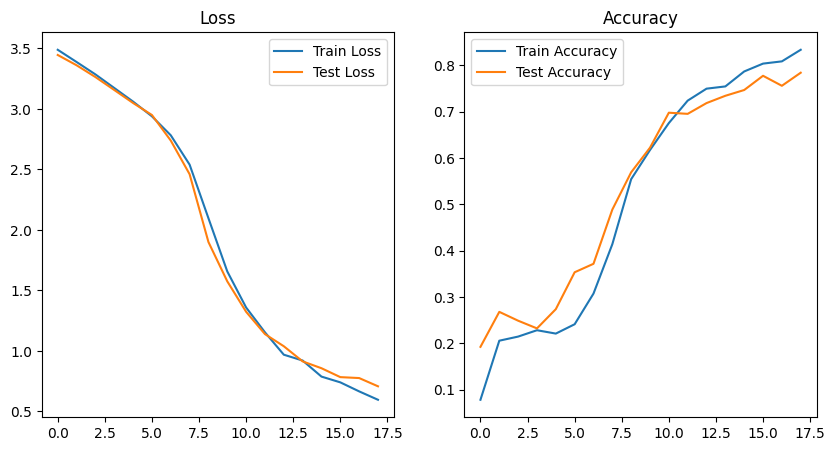

In [25]:
metrics = {
    'train_loss': history['train_loss'],
    'train_acc': [t.cpu().item() for t in history['train_acc']],
    'test_loss': history['test_loss'],
    'test_acc': [t.cpu().item() for t in history['test_acc']]
}

print(metrics)

# Plot the training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [27]:
# added below - RK

train_size = dataset_sizes['train']
test_size = dataset_sizes['test']

print(f"Train Size: {train_size}")
print(f"Test Size: {test_size}")

Train Size: 1239
Test Size: 1205


In [28]:
# added below - RK

train_loader = dataloaders['train']
test_loader = dataloaders['test']

In [37]:
# save the trained model
torch.save(model, '/content/drive/MyDrive/Datasets/GroceryStoreDataset2/complete_model.pth')

# added below - RK

# Store predictions and actual labels
all_preds = []
all_labels = []

model.eval()  # set to evaluation mode

# Turn off gradient tracking – useful during evaluation/testing (faster and uses less memory)
with torch.no_grad():
    # Loop through the test data loader in batches
    for images, labels in test_loader:
        # Move images and labels to the same device as the model (e.g., GPU if available)
        images = images.to(device)
        labels = labels.to(device)

        # Pass the images through the model to get predictions
        outputs = model(images)

        # Take the index of the highest score (predicted class) from model outputs
        # _ (underscore) is a convention used when you don’t need a variable, so only predicted we care about
        _, predicted = torch.max(outputs, 1)

        # Convert predicted labels from tensor to numpy and add to a list
        all_preds.extend(predicted.cpu().numpy())

        # Do the same for actual labels
        all_labels.extend(labels.cpu().numpy())


In [32]:
# After training
predict_image('/content/drive/MyDrive/Datasets/GroceryStoreDataset2/test/Mango/Mango_002.jpg', model, class_names)
predict_image('/content/drive/MyDrive/Datasets/GroceryStoreDataset2/test/Pineapple/Pineapple_021.jpg', model, class_names)


Predicted Class: Mango, Confidence: 54.57%
Predicted Class: Pineapple, Confidence: 49.26%


### Project:

1. Perform exploratory data analysis on the 'train' and 'test' datasets to calculate class imbalance (by comparing 'samples per class' across all the classes)
2. Print confusion matrix, precision, recall and f1-score
3. Show a grid of 6x4 images, with actual and predicted class for each of those


### Bonus Project:

1. Allow user to input the items they shopped using images, use model to identify grocery item based on confidence threshold. If confidence is low, ask user to manually input the item.
2. Update the digital grocery cart
3. Process the transaction by generating a transaction receipt


In [68]:
base_path = '/content/drive/MyDrive/Datasets/GroceryStoreDataset2'

print("Folders inside base_path:")
print(os.listdir(base_path))

Folders inside base_path:
['test', 'train', 'complete_model.pth']


In [69]:
#train_path = '/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train'
#test_path = '/content/drive/MyDrive/Datasets/GroceryStoreDataset2/test'

In [70]:
def is_image_file(filename):
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

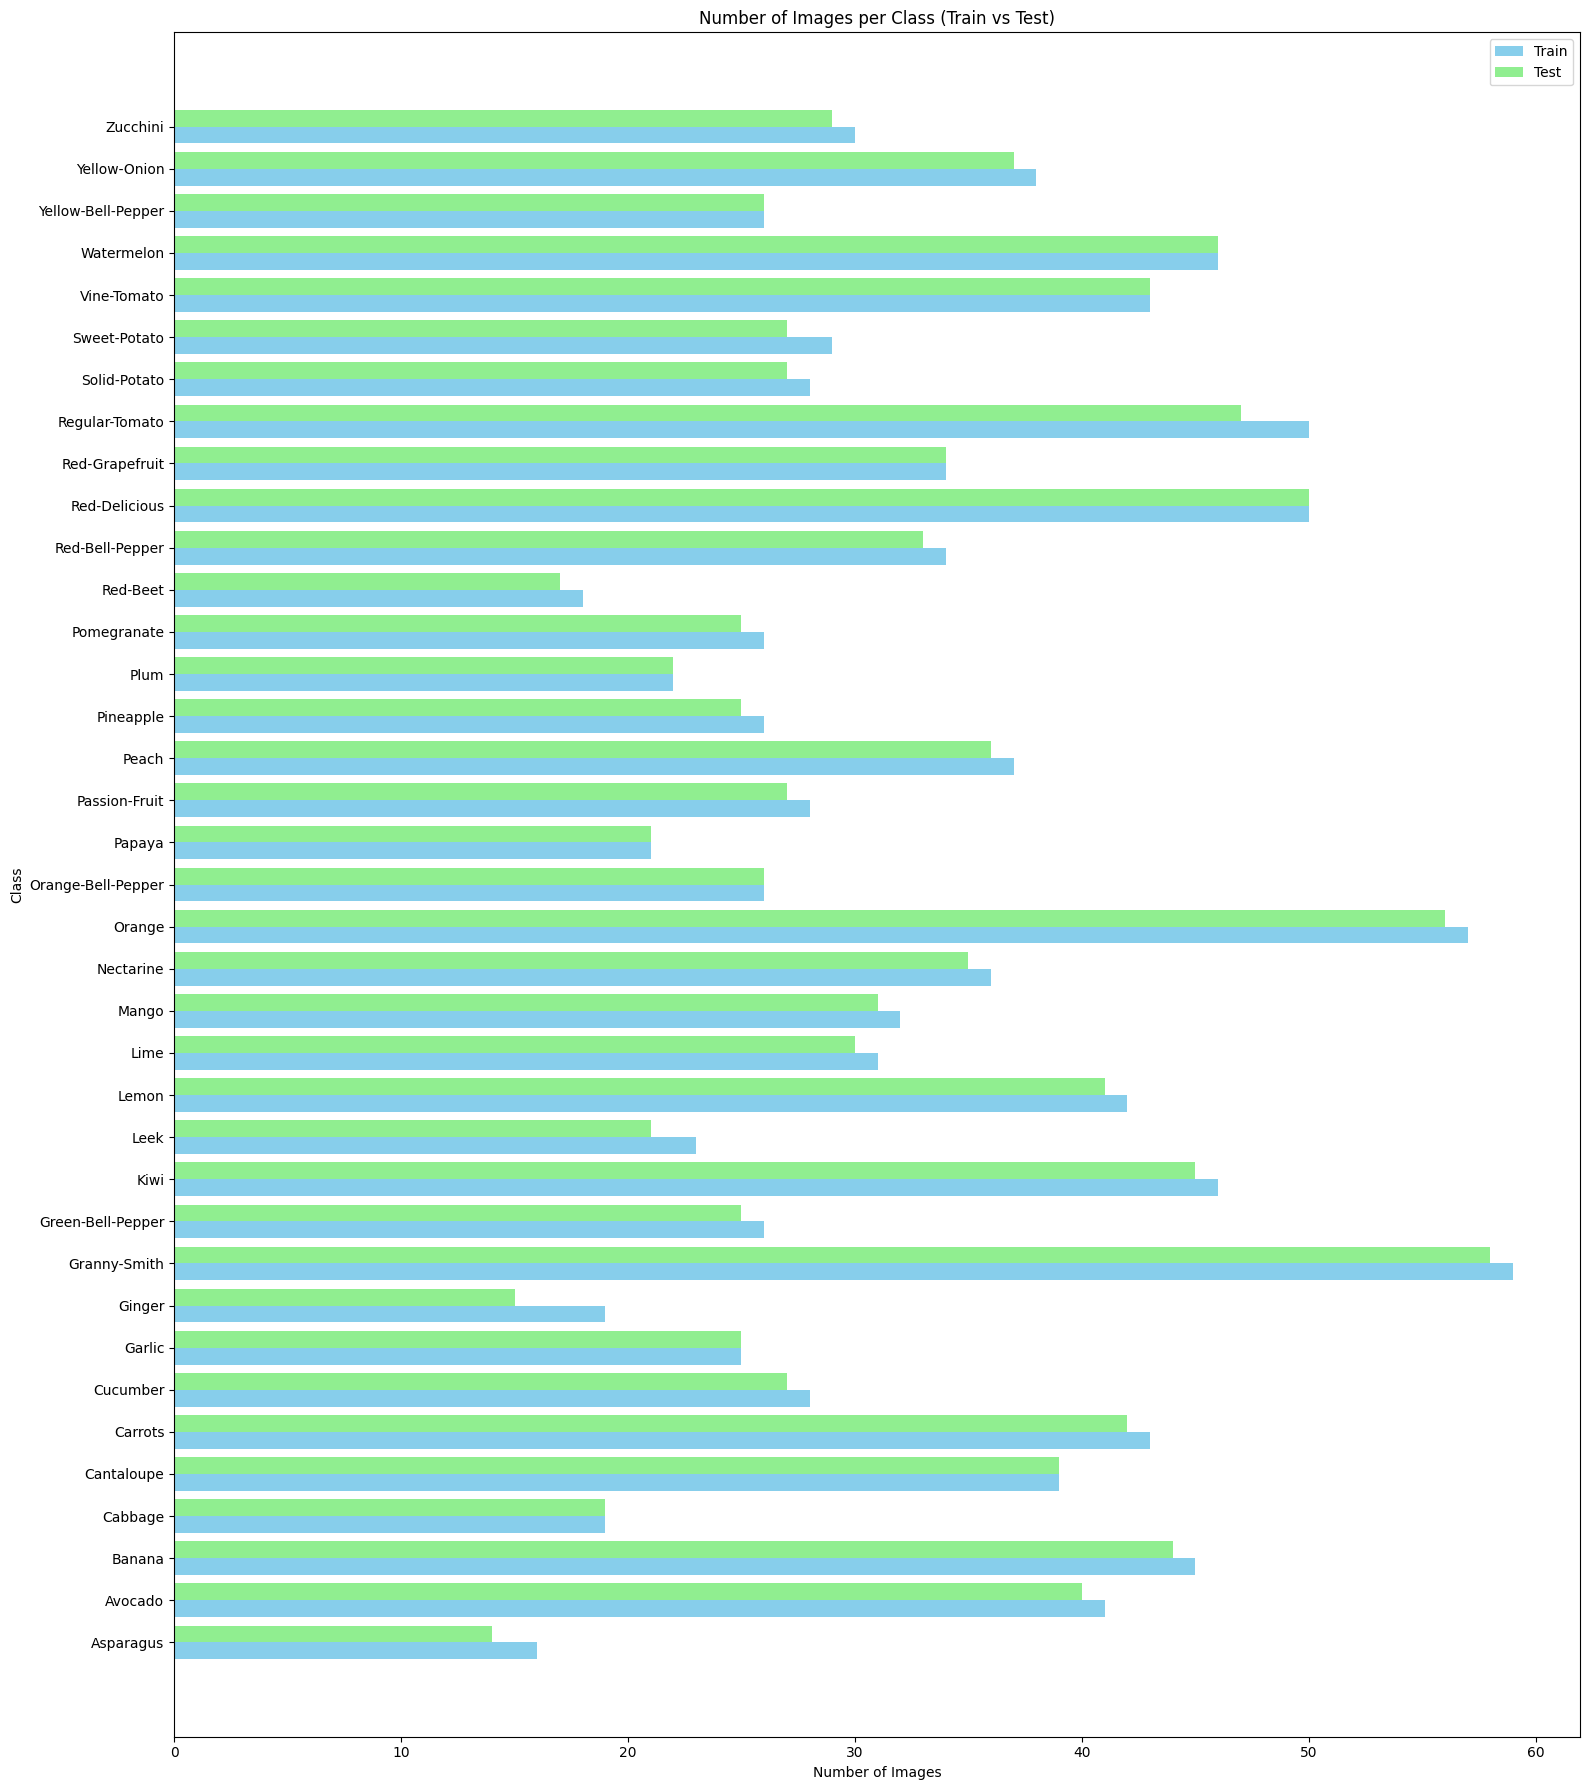

In [71]:
# 1) Perform exploratory data analysis on the 'train' and 'test' datasets to calculate class imbalance (by comparing 'samples per class' across all the classes)
def get_leaf_class_counts(folder_path):
    """
    Go through every folder and subfolder, and count the number of image files
    in each 'leaf' folder (a folder that has no other folders inside it).
    Returns a dictionary where the key is the folder name and the value is the number of images.
    """
    class_counts = {}  # store the counts for each leaf folder

    # walk through every folder and subfolder
    for root, dirs, files in os.walk(folder_path):

        # if there are no subfolders inside this folder, it is a 'leaf' folder (just the fruit/vegetable)
        if len(dirs) == 0:
            image_files = []  # store valid image files

            # loop through every file in the folder
            for filename in files:
                # check if it's an image file (jpg, jpeg, png)
                if is_image_file(filename):
                    image_files.append(filename)

            # get the name of the current folder (ex: 'Tomato')
            class_name = os.path.basename(root)

            # save the count of image files in this folder
            class_counts[class_name] = len(image_files)

    return class_counts

# folder paths, defined again here for reference
train_path = '/content/drive/MyDrive/Datasets/GroceryStoreDataset2/train'
test_path = '/content/drive/MyDrive/Datasets/GroceryStoreDataset2/test'

# count images per class
train_counts = get_leaf_class_counts(train_path)
test_counts = get_leaf_class_counts(test_path)

# merge all class names
# creates a sorted list of all unique class names that appear in either the train or test dataset.
# .union() method combines two sets and removes duplicates.
all_classes = sorted(set(train_counts.keys()).union(set(test_counts.keys())))

# create lists of image counts that match the order of class names in all_classes, for both the train and test datasets.
train_values = [train_counts.get(c, 0) for c in all_classes]
test_values = [test_counts.get(c, 0) for c in all_classes]

# added a taller height helps avoid overlapping labels for many classes
plt.figure(figsize=(16, 18))

# create a list of y-axis positions for each class (e.g., [0, 1, 2, ..., n-1])
# bars will be placed vertically here (for space reasons)
y_positions = list(range(len(all_classes)))

# plot the horizontal bars for the train dataset

# - barh() creates horizontal bars
# - y_positions is where the bars go on the y-axis
# - train_values is the length of the bars (number of images per class)
# - height=0.4 controls bar thickness
# - color and label are for appearance and the legend

plt.barh(y_positions, train_values, height=0.4, color='skyblue', label='Train')

# plot the horizontal bars for the test dataset, slightly lower than the train dataset bars to avoid overlap

# y + 0.4 shifts each test bar down a bit so it's below the train bar
plt.barh([y + 0.4 for y in y_positions], test_values, height=0.4, color='lightgreen', label='Test')

plt.title('Number of Images per Class (Train vs Test)')
plt.xlabel('Number of Images')
plt.ylabel('Class')

# set the class names as labels on the y-axis
# y + 0.2 centers the label between the train and test bars
plt.yticks(ticks=[y + 0.2 for y in y_positions], labels=all_classes)

# display a legend so that it is easy to determine which color corresponds to train/test)
plt.legend()

# adjust spacing to make sure nothing is cut off
plt.tight_layout()

plt.show()


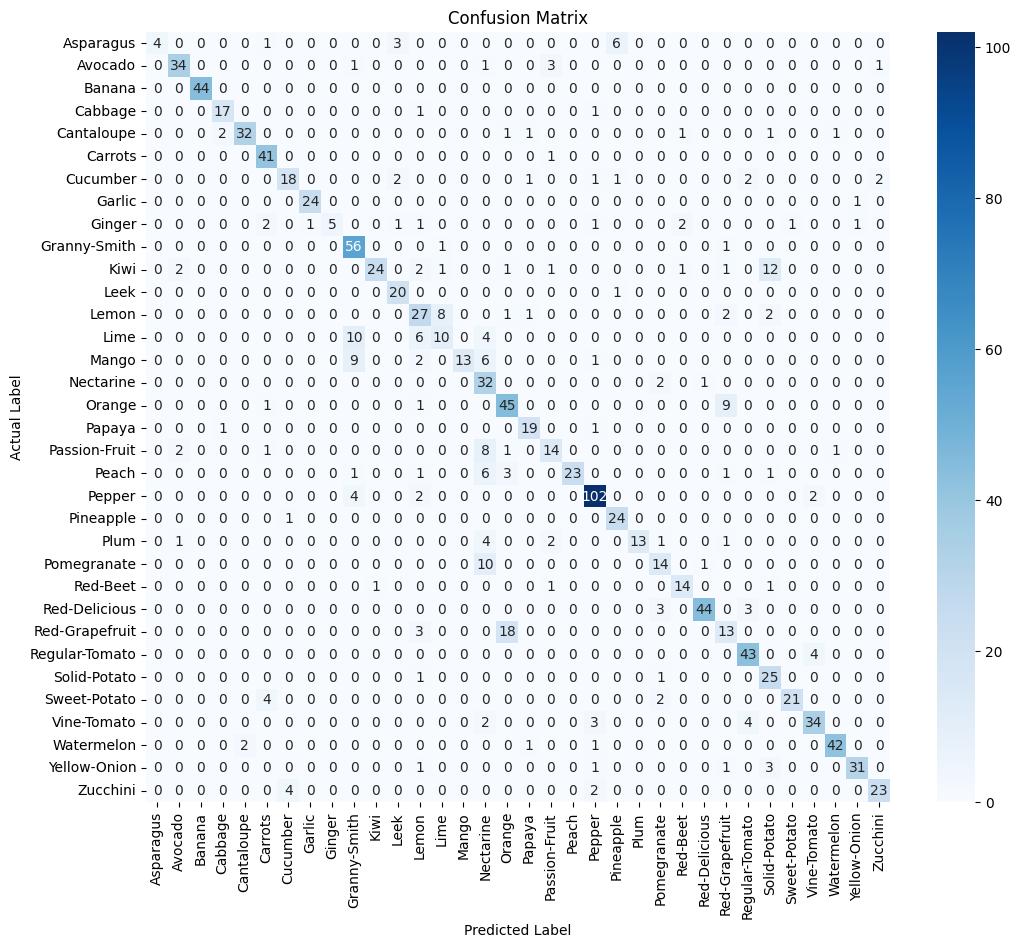

Classification Report:

                precision    recall  f1-score   support

     Asparagus       1.00      0.29      0.44        14
       Avocado       0.87      0.85      0.86        40
        Banana       1.00      1.00      1.00        44
       Cabbage       0.85      0.89      0.87        19
    Cantaloupe       0.94      0.82      0.88        39
       Carrots       0.82      0.98      0.89        42
      Cucumber       0.78      0.67      0.72        27
        Garlic       0.96      0.96      0.96        25
        Ginger       1.00      0.33      0.50        15
  Granny-Smith       0.69      0.97      0.81        58
          Kiwi       0.96      0.53      0.69        45
          Leek       0.77      0.95      0.85        21
         Lemon       0.56      0.66      0.61        41
          Lime       0.50      0.33      0.40        30
         Mango       1.00      0.42      0.59        31
     Nectarine       0.44      0.91      0.59        35
        Orange       0.

In [61]:
# 2) Print confusion matrix, precision, recall and f1-score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class_names = image_datasets['test'].classes

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Print precision, recall, f1-score
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [64]:
display("All done!")
print("All done")

'All done!'

All done
